### Setup before Gaia Exam

In [1]:
!pip install supabase
!pip install  IPython
!pip install  langchain
!pip install  langgraph
!pip install python-dotenv
!pip install langchain-core
!pip install  langchain-community
!pip install  langchain-huggingface
!pip install  sentence-transformers
!pip install  langchain-google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.2/440.2 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 16.9 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.66
    Uninstalling langchain-core-0.3.66:
      Successfully uninstalled langchain-core-0.3.66
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

### Load and test JSON data

In [2]:
import json
import random

with open('METADATA.jsonl', 'r') as jsonl_file:
    json_list = list(jsonl_file)

json_QA = []

for json_str in json_list:

    json_data = json.loads(json_str)
    json_QA.append(json_data)

### Randomly select 3 samples

random_samples = random.sample(json_QA, 1)

for sample in random_samples:

    print("=" * 50)
    print(f"Task ID: {sample['task_id']}")
    print(f"Question: {sample['Question']}")
    print(f"Level: {sample['Level']}")

    print(f"Final Answer: {sample['Final answer']}")
    print(f"Annotator Metadata: ")

    print(f"  ├── Steps: ")

    for step in sample['Annotator Metadata']['Steps'].split('\n'):
        print(f"  │      ├── {step}")

    print(f"  ├── Number of steps: {sample['Annotator Metadata']['Number of steps']}")
    print(f"  ├── How long did this take?: {sample['Annotator Metadata']['How long did this take?']}")

    print(f"  ├── Tools:")

    for tool in sample['Annotator Metadata']['Tools'].split('\n'):
        print(f"  │      ├── {tool}")

    print(f"  └── Number of tools: {sample['Annotator Metadata']['Number of tools']}")

print("=" * 50)

Task ID: cf106601-ab4f-4af9-b045-5295fe67b37d
Question: What country had the least number of athletes at the 1928 Summer Olympics? If there's a tie for a number of athletes, return the first in alphabetical order. Give the IOC country code as your answer.
Level: 1
Final Answer: CUB
Annotator Metadata: 
  ├── Steps: 
  │      ├── 1. Look up the 1928 Summer Olympics on Wikipedia
  │      ├── 2. Look at a table of athletes from countries.
  │      ├── 3. See that two countries had 1 and 2 athletes, so disregard those and choose the Cuba as CUB.
  ├── Number of steps: 3
  ├── How long did this take?: 5 minutes
  ├── Tools:
  │      ├── None
  └── Number of tools: 0


### Connect to Supabase DB

In [3]:
### Build a vector database based on the metadata.jsonl
# https://python.langchain.com/docs/integrations/vectorstores/supabase/

import os

from dotenv import load_dotenv
from google.colab import userdata
from huggingface_hub import login
from langchain.schema import Document
from supabase.client import Client, create_client
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import SupabaseVectorStore

hf_token = userdata.get("HF_TOKEN")
login(token=hf_token)

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

supabase_url = userdata.get('SUPABASE_URL')
supabase_key = userdata.get('SUPABASE_KEY')

supabase: Client = create_client(supabase_url, supabase_key)

### Wrap the metadata.jsonl's questions and answers into a list of document

docs = []

for sample in json_QA:

    content = f"Question : {sample['Question']}\n\nFinal answer : {sample['Final answer']}"
    doc = {"content" : content,
           "metadata" : {"source" : sample['task_id']},
           "embedding" : embeddings.embed_query(content)}

    docs.append(doc)

### Upload the documents to the vector database

try:
    response = (supabase.table("documents")
                .insert(docs)
                .execute())

except Exception as exception:
    print("Error inserting data into Supabase:", exception)

### ALTERNATIVE : Save the documents into a csv file, and manually upload it to Supabase

import pandas as pd
df = pd.DataFrame(docs)
df.to_csv('DB_DATA.csv', index=False)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Add items to Supabase DB

In [4]:
### Add items to vector database

vector_store = SupabaseVectorStore(

    client=supabase,
    embedding= embeddings,

    table_name="documents",
    query_name="match_documents_langchain")

retriever = vector_store.as_retriever()

### Listing tools

In [5]:
### List of the tools used in all the samples

from collections import Counter, OrderedDict

tools = []

for sample in json_QA:
    for tool in sample['Annotator Metadata']['Tools'].split('\n'):

        tool = tool[2:].strip().lower()

        if tool.startswith("("):
            tool = tool[11:].strip()

        tools.append(tool)

tools_counter = OrderedDict(Counter(tools))

print("List of tools used in all samples:")
print("Total number of tools used:", len(tools_counter))

for tool, count in tools_counter.items():
    print(f"  ├── {tool}: {count}")

List of tools used in all samples:
Total number of tools used: 83
  ├── web browser: 107
  ├── image recognition tools (to identify and parse a figure with three axes): 1
  ├── search engine: 101
  ├── calculator: 34
  ├── unlambda compiler (optional): 1
  ├── a web browser.: 2
  ├── a search engine.: 2
  ├── a calculator.: 1
  ├── microsoft excel: 5
  ├── google search: 1
  ├── ne: 9
  ├── pdf access: 7
  ├── file handling: 2
  ├── python: 3
  ├── image recognition tools: 12
  ├── jsonld file access: 1
  ├── video parsing: 1
  ├── python compiler: 1
  ├── video recognition tools: 3
  ├── pdf viewer: 7
  ├── microsoft excel / google sheets: 3
  ├── word document access: 1
  ├── tool to extract text from images: 1
  ├── a word reversal tool / script: 1
  ├── counter: 1
  ├── excel: 3
  ├── image recognition: 5
  ├── color recognition: 3
  ├── excel file access: 3
  ├── xml file access: 1
  ├── access to the internet archive, web.archive.org: 1
  ├── text processing/diff tool: 1
  ├── gi

### Prompt creation

In [7]:
system_prompt = """You are a helpful assistant tasked with answering questions using a set of tools.
                   If the tool is not available, you can try to find the information online. You can also use your own knowledge to answer the question.
                   You need to provide a step-by-step explanation of how you arrived at the answer.
                   ==========================
                   Here is a few examples showing you how to answer the question step by step."""

for i, samples in enumerate(random_samples):
    system_prompt += f"\nQuestion {i+1}: {samples['Question']}\nSteps:\n{samples['Annotator Metadata']['Steps']}\nTools:\n{samples['Annotator Metadata']['Tools']}\nFinal Answer: {samples['Final answer']}\n"

system_prompt += "\n==========================\n"
system_prompt += "Now, please answer the following question step by step.\n"

### Save the system_prompt to a file

with open('PROMPT.txt', 'w') as f:
    f.write(system_prompt)

### Load the system prompt from the file

with open('PROMPT.txt', 'r') as f:
    system_prompt = f.read()

print(system_prompt)

You are a helpful assistant tasked with answering questions using a set of tools.
                   If the tool is not available, you can try to find the information online. You can also use your own knowledge to answer the question.
                   You need to provide a step-by-step explanation of how you arrived at the answer.
                   Here is a few examples showing you how to answer the question step by step.
Question 1: What country had the least number of athletes at the 1928 Summer Olympics? If there's a tie for a number of athletes, return the first in alphabetical order. Give the IOC country code as your answer.
Steps:
1. Look up the 1928 Summer Olympics on Wikipedia
2. Look at a table of athletes from countries.
3. See that two countries had 1 and 2 athletes, so disregard those and choose the Cuba as CUB.
Tools:
None
Final Answer: CUB

Now, please answer the following question step by step.



### Script - *AI_agent.py*

In [11]:
import dotenv

from google.colab import userdata
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from supabase.client import Client, create_client
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.tools.retriever import create_retriever_tool
from langchain_community.document_loaders import ArxivLoader
from langgraph.graph import MessagesState, START, StateGraph
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.vectorstores import SupabaseVectorStore
from langchain_community.tools.tavily_search import TavilySearchResults

### Define the retriever from supabase

load_dotenv()
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2") #  dim=768

supabase_url = userdata.get('SUPABASE_URL')
supabase_key = userdata.get('SUPABASE_KEY')
supabase: Client = create_client(supabase_url, supabase_key)

vector_store = SupabaseVectorStore(client=supabase,
                                   embedding= embeddings,
                                   table_name="documents",
                                   query_name="match_documents_langchain")

question_retrieve_tool = create_retriever_tool(
                         vector_store.as_retriever(),

                         "Question Retriever",
                         "Find similar questions in the vector database for the given question.")

@tool
def multiply(a: int, b: int) -> int:

    """
    Multiply two numbers -

    Args:
        a: first int
        b: second int
    """
    return a * b

@tool
def add(a: int, b: int) -> int:

    """
    Add two numbers -

    Args:
        a: first int
        b: second int
    """
    return a + b

@tool
def subtract(a: int, b: int) -> int:

    """
    Subtract two numbers -

    Args:
        a: first int
        b: second int
    """
    return a - b

@tool
def divide(a: int, b: int) -> int:

    """
    Divide two numbers -

    Args:
        a: first int
        b: second int
    """

    if b == 0:
        raise ValueError("Cannot divide by zero.")

    return a / b

@tool
def modulus(a: int, b: int) -> int:

    """
    Get the modulus of two numbers -

    Args:
        a: first int
        b: second int
    """
    return a % b

@tool
def wiki_search(query: str) -> str:

    """
    Search Wikipedia for a query and return maximum 2 results -

    Args:
        query: The search query.
    """

    search_docs = WikipediaLoader(query=query, load_max_docs=2).load()

    formatted_search_docs = "\n\n---\n\n".join(
        [f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
        for doc in search_docs])

    return {"wiki_results": formatted_search_docs}

@tool
def web_search(query: str) -> str:

    """
    Search Tavily for a query and return maximum 3 results -

    Args:
        query: The search query.
    """

    search_docs = TavilySearchResults(max_results=3).invoke(query=query)

    formatted_search_docs = "\n\n---\n\n".join(
        [f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
        for doc in search_docs])

    return {"web_results": formatted_search_docs}

@tool
def arvix_search(query: str) -> str:

    """
    Search Arxiv for a query and return maximum 3 result -

    Args:
        query: The search query.
    """

    search_docs = ArxivLoader(query=query, load_max_docs=3).load()

    formatted_search_docs = "\n\n---\n\n".join(
        [f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content[:1000]}\n</Document>'
        for doc in search_docs])

    return {"arvix_results": formatted_search_docs}

@tool
def similar_question_search(question: str) -> str:

    """
    Search the vector database for similar questions and return the first results -

    Args:
        question: the question human provided.
    """
    matched_docs = vector_store.similarity_search(query, 3)

    formatted_search_docs = "\n\n---\n\n".join(
        [f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content[:1000]}\n</Document>'
        for doc in matched_docs])

    return {"similar_questions": formatted_search_docs}

tools = [add,
         divide,
         modulus,
         subtract,
         multiply,
         web_search,
         wiki_search,
         arvix_search,
         question_retrieve_tool]

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)

In [12]:
### Load the system prompt from the file

with open('PROMPT.txt', 'r') as f:
    system_prompt = f.read()

### System message

sys_msg = SystemMessage(content=system_prompt)

### Node

def assistant(state: MessagesState):

    """Assistant node"""
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

### Build graph

builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)

builder.add_edge("tools", "assistant")
graph = builder.compile()

### Thought display

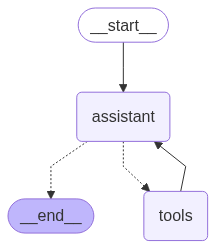

/usr/local/lib/python3.11/dist-packages/langchain_google_genai/chat_models.py:1663: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(
ERROR:grpc._plugin_wrapping:AuthMetadataPluginCallback "<google.auth.transport.grpc.AuthMetadataPlugin object at 0x7864200e4710>" raised exception!
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/google/auth/compute_engine/credentials.py", line 126, in refresh
    self._retrieve_info(request)
  File "/usr/local/lib/python3.11/dist-packages/google/auth/compute_engine/credentials.py", line 99, in _retrieve_info
    info = _metadata.get_service_account_info(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/google/auth/compute_engine/_metadata.py", line 338, in get_service_account_info
    return get(request, path, params={"recursive": "true"})
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.

KeyboardInterrupt: 

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

question = ""
messages = [HumanMessage(content=question)]
messages = graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()